In [1]:
import tensorflow as tf
import pandas as pd
from transformers import BertTokenizer, TFBertForSequenceClassification

In [35]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt


In [3]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('Sentiment_news_dataframe.csv')


In [4]:
#drop irrelevant columns
df = df.drop(['Date','URL','confidence','Unnamed: 5'], axis=1)
df.head()

,Title,sentiment
0,Amber Enterprises files for Rs555 crore IPO,NEGATIVE
1,No need to divorce this stock ; brokerage sees...,POSITIVE
2,An evening walk down Dalal Street : Trade war ...,POSITIVE
3,Commodity outlook : Refined soya oil jumps 8 %...,NEGATIVE
4,Nikkei : Tokyo stocks open lower after British...,NEGATIVE


In [5]:
#drop duplicates in column "Title"
df = df.drop_duplicates(subset=["Title"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59973 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      59973 non-null  object
 1   sentiment  59973 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [6]:
df = df.rename(columns = {'Title': 'text'})
df['text'] = df['text'].astype(str)
df = df.rename(columns = {'sentiment': 'Label'})
df['Label'] = df['Label'].astype(str)


In [7]:
# Split the dataset into training and validation sets
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)


In [8]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [9]:
# Encode the training and validation sets
train_encodings = tokenizer(list(train_df["text"]), truncation=True, padding=True)
val_encodings = tokenizer(list(val_df["text"]), truncation=True, padding=True)


In [10]:
# Convert labels to integers
train_labels = [1 if label == "POSITIVE" else 0 for label in list(train_df["Label"])]
val_labels = [1 if label == "POSITIVE" else 0 for label in list(val_df["Label"])]


In [11]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))


In [12]:
# Load the pre-trained BERT model
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Set up the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [14]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


In [15]:
# Train the model
model.fit(train_dataset.shuffle(len(train_df)).batch(32), epochs=3, batch_size=32, validation_data=val_dataset.batch(32))


Epoch 1/3
1500/1500 [==============================] - 24766s 16s/step - loss: 0.3873 - accuracy: 0.8236 - val_loss: 0.3370 - val_accuracy: 0.8489
Epoch 2/3
1500/1500 [==============================] - 24288s 16s/step - loss: 0.2259 - accuracy: 0.9078 - val_loss: 0.3629 - val_accuracy: 0.8528
Epoch 3/3
1500/1500 [==============================] - 26544s 18s/step - loss: 0.1226 - accuracy: 0.9541 - val_loss: 0.4405 - val_accuracy: 0.8474


In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt


In [20]:
# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(train_dataset.batch(32))
print("Train accuracy:", train_acc)


1500/1500 [==============================] - 7327s 5s/step - loss: 0.0421 - accuracy: 0.9864
Train accuracy: 0.9864313006401062


In [21]:
# Calculate test accuracy
test_loss, test_accuracy = model.evaluate(val_dataset.batch(32), verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')


Test accuracy: 0.8474


In [26]:
# Get predictions
y_pred_logits = model.predict(val_dataset.batch(32))
y_pred = np.argmax(y_pred_logits.logits, axis=1)


375/375 [==============================] - 1959s 5s/step


In [28]:
# Calculate evaluation metrics
print("\nClassification report:")
print(classification_report(val_labels, y_pred))



Classification report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      6091
           1       0.83      0.86      0.85      5904

    accuracy                           0.85     11995
   macro avg       0.85      0.85      0.85     11995
weighted avg       0.85      0.85      0.85     11995



In [34]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(val_labels, y_pred, average='binary')

print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1_score)


Precision: 0.8332787958115183
Recall: 0.8626355013550135
F1 score: 0.8477030625832223


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt


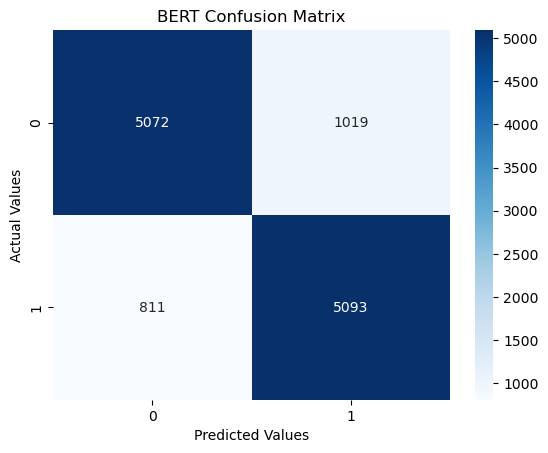

In [30]:

conf_matrix = confusion_matrix(val_labels, y_pred)
# Visualize confusion matrix with heatmap
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('BERT Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

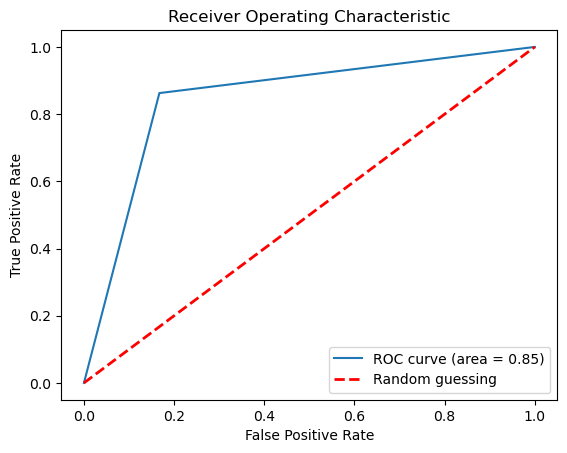

In [32]:
# Calculate ROC curve and AUC

fpr, tpr, thresholds = roc_curve(val_labels, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

